In [ ]:
!python3 -m pip install cython
!python3 -m pip install PyMySQL
!python3 -m pip install SQLAlchemy
!python3 -m pip install google-cloud-storage
!python3 -m pip install --upgrade --quiet scikit-sound
!python3 -m pip install --upgrade --quiet pygame
!python3 -m pip install scikit-learn==0.21rc2

!sudo apt-get -y install ffmpeg
!sudo apt-get -y install python3-pymysql

In [28]:
import sqlalchemy
import numpy as np

from google.cloud import storage
from numpy.fft import fft, ifft
from sksound.sounds import Sound

from tensorflow.keras.models import load_model

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
%load_ext Cython

In [29]:
# PASSWORDS AND STUFF HERE

In [30]:
settings = {
   'user': db_user,
   'pass': db_password,
   'host': host,
     'db': db_name
}
url = 'mysql+pymysql://{user}:{pass}@{host}/{db}'.format(**settings)  # 5432 is the default port
db = sqlalchemy.create_engine(url)

def run_query(query):
    with db.connect() as conn:
        rows = []
        for row in conn.execute(query).fetchall():
            rows.append(dict(row.items()))
        return rows
    
regions = run_query("""
    SELECT 
        x.encoding, y.year, x.filename, x.start, x.stop
    FROM 
        wdp_ds.not_silent x
    JOIN 
        wdp_ds.encoding y 
    ON x.encoding = y.encoding;
""")

In [31]:
client = storage.Client.from_service_account_json('secret.json')
bucket = client.get_bucket('wdp-data')

In [8]:
regions_by_file = {}
for region in regions:
    k = "audio_files/{}/{}".format(region['year'], region['filename'])
    r = region
    if k not in regions_by_file:
        regions_by_file[k] = []
    regions_by_file[k].append(r)
print(len(regions_by_file))

45


In [9]:
class StreamSpectrogram:
    
    def __init__(self, filename, starts, stops, win=32, filter=25):
        sound = Sound(filename)      
        self.ranges = [x for x in zip(starts, stops)]
        self.starts = starts
        self.stops = stops
        self.data  = sound.data
        self.fs    = sound.rate
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win
        self.filter = filter

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):        
        if self.i < len(self.ranges): 
            start, stop = self.ranges[self.i]
            raw   = self.data[start:stop]
            spec  = fwd_spectrogram(raw) 
            t,d   = spec.shape
            if t > self.win:
                spec[:self.filter] = 0.0
                current = []        
                for i in range(self.win, t + 1, self.win // 2):
                    x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
                    mu     = np.mean(x)
                    std    = np.std(x) + 1.0
                    window = (x - mu) / std
                    current.append(window)
                self.i += 1
                return np.stack(current)
            else:
                self.i += 1
                return None
        else:
            raise StopIteration
        
def fwd_spectrogram(audio, win=512, step=256):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [10]:
encoder = load_model('encoder.h5')
idx     = list(regions_by_file.keys()) 
files   = {}
latent  = [] 
for path in idx:    
    with open("/tmp/audio.m4a", "wb") as file_obj:
        blob = bucket.blob(path)
        blob.download_to_file(file_obj)
    stream = StreamSpectrogram("/tmp/audio.m4a", [r['start'] for r in regions_by_file[path]], [r['stop'] for r in regions_by_file[path]])
    for i, region in enumerate(stream):
        r = regions_by_file[path][i]
        x = region
        if x is not None:
            h = encoder.predict(x)
            latent.append([h, r])

Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


In [ ]:
import pickle
pickle.dump( latent, open( "data.p", "wb" ) )

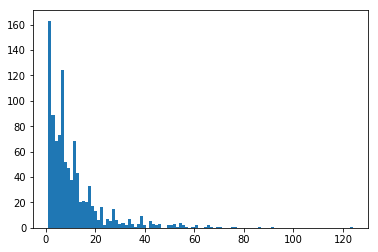

In [9]:
import pickle
import matplotlib.pyplot as plt

latent = pickle.load( open( "data.p", "rb" ) )
x = [len(l[0]) for l in latent]
plt.hist(x, bins=100)
plt.show()

In [ ]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np

DTYPE = np.float

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(0, m+1):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                dp[i - 1][j    ],
                dp[i    ][j - 1]
            )
    return dp[n][m]

latent = pickle.load( open( "data.p", "rb" ) )
n = len(latent)
distances = np.ones((n, n)) * float('inf')
for i, x in enumerate(latent):
    if i % 10 == 0:
        print("{} / {}".format(i, n))
    for j, y in enumerate(latent):
        if abs(len(x[0]) - len(y[0])) < 10 and i < j:  
            distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

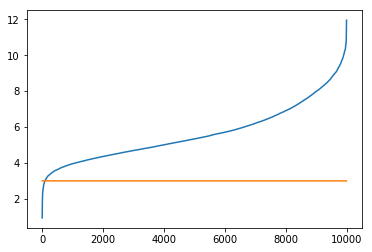

2.992171582221985


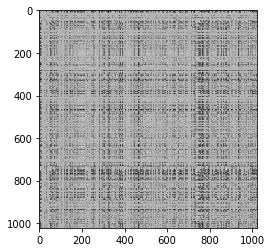

In [20]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

for i in range(len(distances)):
    for j in range(len(distances)):
        if not np.isinf(distances[i][j]):
            distances[i][j] /= len(latent[i][0]) + len(latent[j][0])

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f, 1)

plt.plot(sorted(f[0:10000]))
plt.plot(np.ones(10000) * th)
plt.show()
print(th)

for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]
        if np.isinf(distances[i][j]):
            distances[i][j] = th + 1

plt.imshow(np.mean(distances) - distances, cmap='gray')
plt.show()

In [21]:
pickle.dump(distances, open( "distances_normal.p", "wb" ) )

In [22]:
import pickle
import matplotlib.pyplot as plt
latent = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances_normal.p", "rb" ) )

In [23]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [24]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='complete', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [25]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    latent[i][1:][0]['cluster'] = cluster_id
    c[cluster_id].append(latent[i][1:][0])

In [26]:
final_clustering = [c for c in c if len(c) > 2]
print(len(final_clustering))
print([len(c) for c in final_clustering])
print(sum([len(c) for c in final_clustering]))

53
[3, 3, 3, 6, 5, 3, 11, 6, 3, 3, 3, 6, 4, 3, 4, 3, 4, 8, 3, 3, 8, 4, 4, 3, 4, 5, 5, 4, 4, 3, 3, 14, 3, 4, 5, 3, 3, 4, 4, 3, 3, 4, 3, 3, 6, 3, 5, 5, 3, 3, 4, 4, 3]
226


In [32]:
with db.connect() as conn:
    id = 0
    for cluster in final_clustering:
        for r in cluster:
            query = "INSERT INTO wdp_ds.clustering_results VALUES({}, {}, '{}', {}, {}, '{}', {}, CURRENT_TIMESTAMP)".format(
                id, r['encoding'], r['filename'], r['start'], r['stop'], 'agglomerative_dtw_tight', r['cluster'])        
            conn.execute(query)  
            id += 1

100
[3, 8, 3, 5, 4, 3, 4, 13, 4, 4, 6, 3, 3, 3, 4, 3, 3, 3, 3, 8, 4, 8, 3, 5, 7, 4, 4, 10, 3, 6, 5, 5, 3, 3, 5, 7, 3, 3, 5, 6, 4, 16, 3, 3, 4, 4, 4, 22, 6, 4, 7, 3, 3, 3, 11, 5, 3, 13, 3, 14, 8, 4, 3, 4, 3, 4, 6, 4, 3, 4, 4, 7, 6, 3, 3, 3, 4, 3, 4, 3, 5, 3, 5, 9, 4, 4, 3, 6, 3, 5, 4, 6, 4, 6, 5, 4, 4, 6, 4, 5]
CLUSTERS:  100
Cluster: 3
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


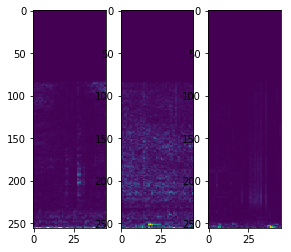

Cluster: 8
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


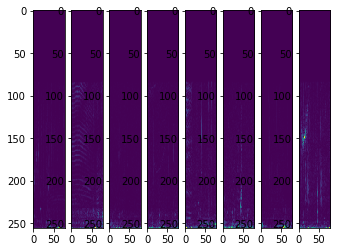

Cluster: 3
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


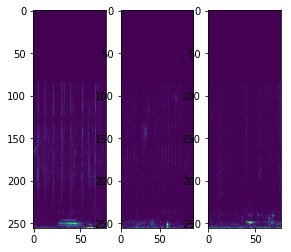

Cluster: 5
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


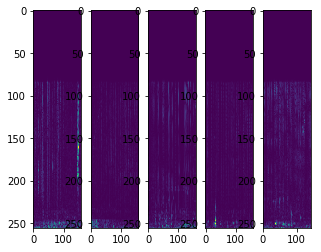

Cluster: 4
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


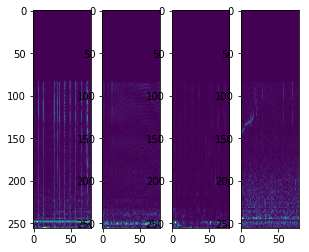

Cluster: 3
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


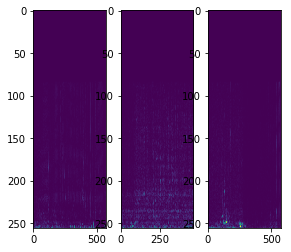

Cluster: 4
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


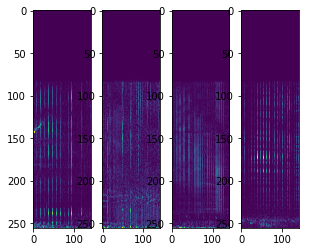

Cluster: 13
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


KeyboardInterrupt: 

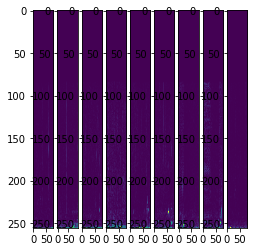

In [58]:
from scipy.io import wavfile

print(len(final_clustering))
print([len(c) for c in final_clustering])

print("CLUSTERS: ", len(final_clustering))
client = storage.Client.from_service_account_json('secret.json')
bucket = client.get_bucket('wdp-data')
cx = 0
for cluster in final_clustering:
    n = len(cluster)
    print("Cluster: {}".format(n))
    
    audio = []
    for i, region in enumerate(cluster):
        path = "audio_files/{}/{}".format(region['year'], region['filename'])
        with open("/tmp/audio.m4a", "wb") as file_obj:
            blob = bucket.blob(path)
            blob.download_to_file(file_obj)
        stream = StreamSpectrogram("/tmp/audio.m4a", [region['start']], [region['stop']])
        spec = fwd_spectrogram(stream.data[region['start']:region['stop']])
       
        audio.extend(stream.data[region['start']:region['stop']])
        audio.extend(np.zeros(stream.fs // 10))    
        
        plt.subplot(1, n + 1, i + 1)
        plt.imshow(spec.T, aspect="auto")
        
    audio = np.array(audio, dtype=audio[0].dtype)
    wavfile.write('cluster_{}.wav'.format(cx), stream.fs, audio)
    plt.savefig('cluster_{}.png'.format(cx), dpi=20 * n)
    cx += 1
    plt.show()